# <center>Naive Bayes</center>
### <center>Calvin Chi</center>

Naive Bayes is a generative classificaiton algorithm. In a generative classification algorithm, we are trying to model $p(x|y)$, where $x$ is the feature and $y$ is the label. In contrast, a distriminative algorithm tries to model $p(y|x)$. Modeling $p(x|y)$ is useful because it can ultimately be used to calculate $p(y|x)$ using Bayes' Rule:

$$p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$

If there are two classes, we would use the above equation twice to calculate the probability of the sample being class $1$ and class $2$ respectively. Since $p(x)$ will be the same in both cases, the denominator is often omitted and we just compare the numerators to see which class is most probable. 

How do we compute $p(x|y)$? Assume that our sample has $n$ features. In Naive Bayes, it is assumed that each $x_{i}$ is conditionally independent of the rest of the $x_{j}'s$ given what $y$ is. Notice how this is different from $x_{i}$ being unconditionally independent from the rest of $x_{j}'s$. In the first case, the independence relationship would be written as:

$$p(x_{i}|x_{j}, y) = p(x_{i}|y)$$

Whereas the independence relationship in the latter case would be written as:

$$p(x_{i}|x_{j}) = p(x_{i})$$ 

The independence assumption is convenient because now the joint probability of a sample with all its features given it belongs to a class can now be written as:

$$p(x_{1},...,x_{n}|y) = \prod_{i=1}^{n}p(x_{i}|y)$$

What is $p(x_{i}|y)$? Assume we have two classes. Also assume that the data comes from the same distribution, but with different distribution paramters, then $p(x_{i}|y)$ is the probability of $x_{i}$ given the density with parameters dictated by $y$. These parameters would be calculated in the training stage, where we are given samples belonging to each class, and our goal would be to calculate the maximum likelihood parameters for each of the classes.

Let us walk through an example. Assume that each of our $x_{i}'s$ are normally distributed with unknown parameters $\mu$ and $\sigma$. Given a training set $x^{(1)},...,x^{(m)}$ with known labels, where $x \in \mathbb{R}^{1xn}$, we would calculate the $\mu$ and $\sigma$ for each $x_{i}$ for each class, and use it to construct to $p(x_{i}|y)$. 

Let us run a simulation by generating $m$ samples where $x \in \mathbb{R}^{1x2}$, and each $x_{i}$ are conditionally independent of the other $x_{j}'s$. Then we will generate another simulation of samples, but this time violating our assumption by introducing a covariance term between each of the $x_{i}'s$. We will be applying Naive Bayes in both cases to evaluate its performance when the assumption is valid and when it is invalid. A normal distribution for each $x_{i}$ is assumed.

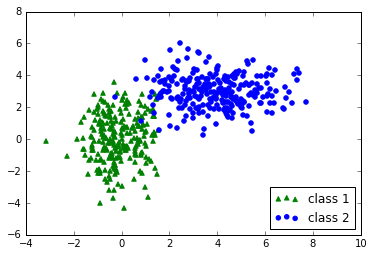

In [34]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

def GenerateSamples(cov=0, N=500):
    y = np.random.randint(2, size=N).reshape((N, 1))
    mean1 = [0, 0]
    cov1 = [[1, cov], [cov, 2]]
    mean2 = [4, 3]
    cov2 = [[2, cov], [cov, 1]] 
    x1 = np.zeros(N).reshape((N, 1))
    x2 = np.zeros(N).reshape((N, 1))
    for i in range(N):
        if y[i] == 0:
            x1[i], x2[i] = np.random.multivariate_normal(mean1, cov1, 1).T
        else:
            x1[i], x2[i] = np.random.multivariate_normal(mean2, cov2, 1).T
    X = np.concatenate((x1, x2), axis=1)
    return X, y

X, y = GenerateSamples()
mat = np.concatenate((X[:,[0]], X[:,[1]], y), axis=1)
class1 = mat[np.where(mat[:,-1] == 0)]
class2 = mat[np.where(mat[:,-1] == 1)]
plt.scatter(class1[:, 0], class1[:, 1], marker="^", color="green", label="class 1")
plt.scatter(class2[:, 0], class2[:, 1], marker="o", color="blue", label="class 2")
plt.legend(loc="lower right")
plt.show()

And next build the Naive Bayes classifier:

In [26]:
import numpy as np
from scipy.stats import norm

class NaiveBayes():
    def train(self, X, Y):
        mat = np.concatenate((X, Y), axis=1)
        n = mat.shape[0]
        self.pdfs = {}
        labels = set(mat[:,-1])
        for i in range(len(labels)):
            subset = mat[np.where(mat[:,-1] == i)]
            self.pdfs[i] = {"mean": np.mean(subset, axis=0),
                         "stdevs": np.std(subset, axis=0), 
                           "prior": subset.shape[0]/n}
    def predict(self, x):
        def probability(sample, parameters):
            prior = parameters["prior"]
            likelihood = norm.pdf(sample[0], parameters["mean"][0], 
                        parameters["stdevs"][0])* norm.pdf(sample[1], 
                        parameters["mean"][1], parameters["stdevs"][1])
            return prior * likelihood
        predictions = []
        for i in range(x.shape[0]):
            probs = []
            sample = x[i, :]
            probs.append(probability(sample, self.pdfs[0]))
            probs.append(probability(sample, self.pdfs[1]))
            predictions.append(probs.index(max(probs)))
        return predictions 

Train, then predict on another dataset drawn from the same distribution as the training set.

In [54]:
bayes = NaiveBayes()
bayes.train(X, y)

X, y = GenerateSamples(cov=0, N=200)
predictions = np.array(bayes.predict(X)).reshape((200, 1))

match = predictions == y
print((sum(match)/len(match))[0])

0.97


And the prediction accuracy is quite high given that assumptions to Naive Bayes hold! We would expect that the more our assumptions are violated, the lower our prediction accuracy. Let us test this by assessing the prediction accuracy as we generate independent datasets with increasing covariance values. 

/Users/calvinchi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: covariance is not positive-semidefinite.
/Users/calvinchi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: covariance is not positive-semidefinite.


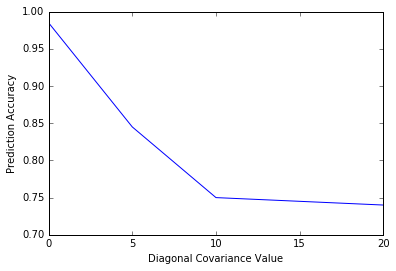

In [56]:
covSet = [0, 5, 10, 15, 20]
accuracies = []
for cov in covSet:
    X, y = GenerateSamples(cov=cov, N=200)
    predictions = np.array(bayes.predict(X)).reshape((200, 1))
    match = predictions == y
    accuracies.append((sum(match)/len(match))[0])  
plt.plot(covSet, accuracies)
plt.ylabel("Prediction Accuracy")
plt.xlabel("Diagonal Covariance Value")
plt.show()

This concludes the Naive Bayes' tutorial!